In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, classification_report
import tensorflow as tf
import pandas as pd
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os



In [2]:
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
img_size = (64, 64)
batch_size = 32

labels = ['closedLeftEyes', 'closedRightEyes', 'openLeftEyes','openRightEyes'] 

datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.2)

train_data = datagen.flow_from_directory(
    r'C:\Users\ADMIN\OneDrive\Desktop\CV_Eye\dataset_B_Eye_Images',
    target_size = img_size, 
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset = 'training'
)

test_data = datagen.flow_from_directory(
    r'C:\Users\ADMIN\OneDrive\Desktop\CV_Eye\dataset_B_Eye_Images',
    target_size = img_size, 
    batch_size = batch_size,
    color_mode = 'grayscale',
    class_mode = 'categorical',
    subset = 'validation'
)

Found 3878 images belonging to 4 classes.
Found 968 images belonging to 4 classes.


In [4]:
def load_data(data):
    x_data, y_data = [], []
    num_batches = len(data)
    for batch in range(num_batches):
        x_batch, y_batch = next(data)
        x_data.append(x_batch)
        y_data.append(y_batch)

    x_data = np.concatenate(x_data, axis = 0)
    y_data = np.concatenate(y_data, axis = 0)

    return x_data, y_data

In [5]:
x_train, y_train, x_test, y_test = [], [], [], []
x_train, y_train = load_data(train_data)
x_test, y_test = load_data(test_data)


In [6]:

model = keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (64,64,1)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu', name = 'feature_extractor'),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(4, activation = 'softmax')
    ])

model.summary()

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor (Dense)       │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,460,612 (9.39 MB)

 Trainable params: 2,460,612 (9.39 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])


In [8]:
features_model = keras.Model(inputs = model.inputs,
                       outputs = model.get_layer('feature_extractor').output)

features_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_extractor (Dense)       │ (None, 128)            │     2,359,424 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,452,096 (9.35 MB)

 Trainable params: 2,452,096 (9.35 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cnn = model.fit(x_train, y_train,
                    epochs = 39,
                    batch_size = batch_size,
                    validation_split = 0.1
                    )
  

Epoch 1/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.3493 - loss: 1.3156 - val_accuracy: 0.6959 - val_loss: 0.8250
Epoch 2/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6931 - loss: 0.7887 - val_accuracy: 0.7629 - val_loss: 0.6531
Epoch 3/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7757 - loss: 0.5950 - val_accuracy: 0.7577 - val_loss: 0.5878
Epoch 4/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.8097 - loss: 0.4850 - val_accuracy: 0.8170 - val_loss: 0.5304
Epoch 5/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8380 - loss: 0.4136 - val_accuracy: 0.7964 - val_loss: 0.5367
Epoch 6/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8466 - loss: 0.4026 - val_accuracy: 0.7938 - val_loss: 0.5128
Epoch 7/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8548 - loss: 0.3643 - val_accuracy: 0.8428 - val_loss: 0.4471
Epoch 8/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8839 - loss: 0.3250 - val_accu

In [10]:
cnn_dict = cnn.history
cnn_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [11]:
display(cnn_dict['accuracy'])

[0.4707736372947693,
 0.7275071740150452,
 0.7911174893379211,
 0.8232091665267944,
 0.842120349407196,
 0.8584527373313904,
 0.8696275353431702,
 0.888538658618927,
 0.8916905522346497,
 0.8959885239601135,
 0.9120343923568726,
 0.9128940105438232,
 0.9303724765777588,
 0.9318051338195801,
 0.93753582239151,
 0.9446991682052612,
 0.9441260695457458,
 0.9478510022163391,
 0.9541547298431396,
 0.9641833901405334,
 0.9578796625137329,
 0.9710601568222046,
 0.970487117767334,
 0.9673352241516113,
 0.9679083228111267,
 0.9733524322509766,
 0.9730659127235413,
 0.9765043258666992,
 0.9753581881523132,
 0.9733524322509766,
 0.969340980052948,
 0.9785100221633911,
 0.9799426794052124,
 0.9888252019882202,
 0.9862464070320129,
 0.9856733679771423,
 0.9779369831085205,
 0.9799426794052124,
 0.9822349548339844]

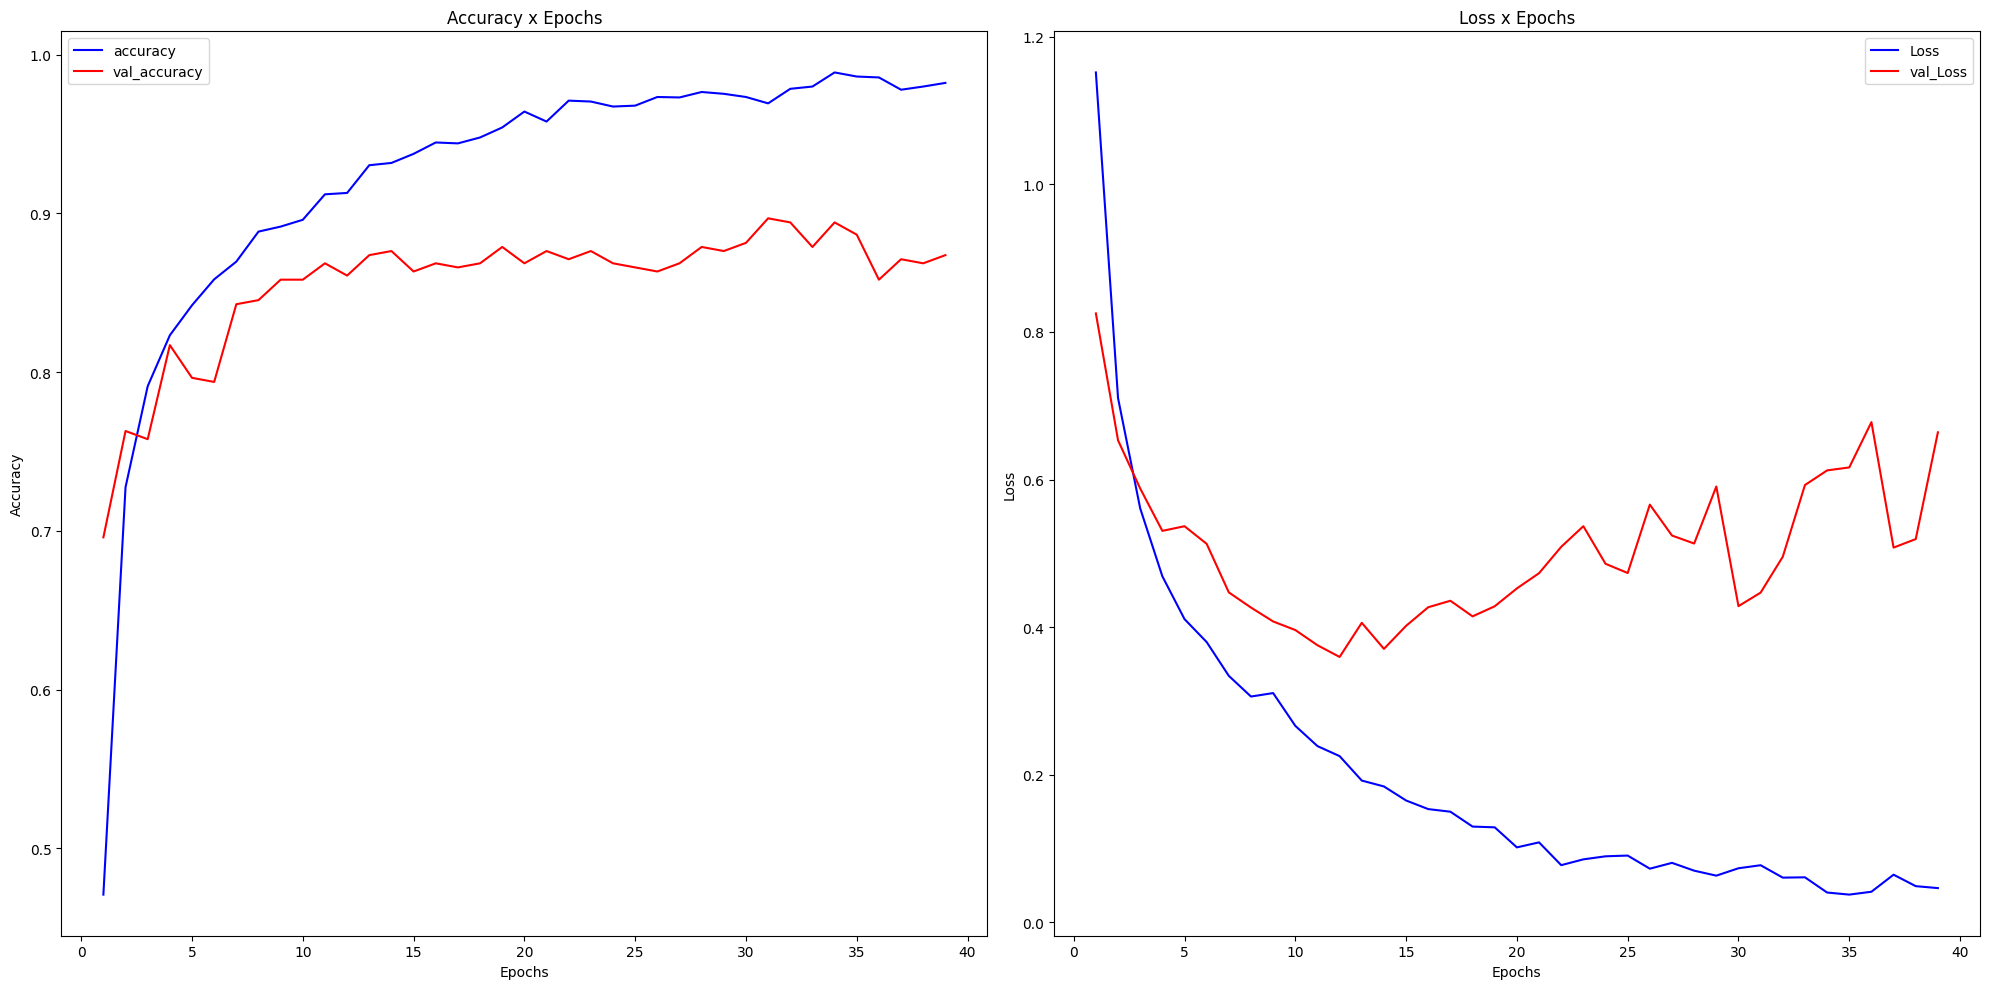

In [12]:
accuracy, loss, val_accuracy, val_loss = cnn_dict['accuracy'], cnn_dict['loss'], cnn_dict['val_accuracy'], cnn_dict['val_loss']
epochs = [i+1 for i in range(39)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.plot(epochs, accuracy, label = 'accuracy', color = 'blue')
ax1.plot(epochs,val_accuracy, label = 'val_accuracy', color = 'red')
ax1.set(title = 'Accuracy x Epochs', xlabel = 'Epochs', ylabel = 'Accuracy')
ax1.legend()

ax2.plot(epochs, loss, label = 'Loss', color = 'blue')
ax2.plot(epochs,val_loss, label = 'val_Loss', color = 'red')
ax2.set(title = 'Loss x Epochs', xlabel = 'Epochs', ylabel = 'Loss')
ax2.legend()

plt.tight_layout()
plt.show()


In [13]:
model = keras.models.Sequential([
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = (64,64,1)),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation = 'relu', name = 'feature_extractor'),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.25),
    layers.Dense(4, activation = 'softmax')
    ])
model.compile(optimizer='adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

cnn = model.fit(x_train, y_train,
                    epochs = 39,
                    batch_size = batch_size,
                    validation_split = 0.1,
                    callbacks = [early_stop]
                    )


Epoch 1/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.3276 - loss: 1.3412 - val_accuracy: 0.6727 - val_loss: 0.8288
Epoch 2/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.6789 - loss: 0.8113 - val_accuracy: 0.7552 - val_loss: 0.6246
Epoch 3/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.7600 - loss: 0.6274 - val_accuracy: 0.7526 - val_loss: 0.5979
Epoch 4/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.8023 - loss: 0.5326 - val_accuracy: 0.7938 - val_loss: 0.5535
Epoch 5/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.8086 - loss: 0.4839 - val_accuracy: 0.7990 - val_loss: 0.5669
Epoch 6/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8299 - loss: 0.4399 - val_accuracy: 0.7938 - val_loss: 0.5292
Epoch 7/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8546 - loss: 0.3796 - val_accuracy: 0.8144 - val_loss: 0.4944
Epoch 8/39
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.8742 - loss: 0.3598 - val_accu

In [15]:
y_pred = model.predict(x_test)

y_prob = np.argmax(y_pred, axis = 1)

y_test_label = np.argmax(y_test, axis = 1) 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [16]:
count = 0
for idx in range(len(y_prob)):
    if y_prob[idx] == y_test_label[idx]:
        count += 1

print(f"Accuracy: {(count/len(y_prob)):.4f}")

Accuracy: 0.8657


In [17]:
report = classification_report(y_test_label, y_prob)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       238
           1       0.88      0.87      0.87       238
           2       0.86      0.87      0.86       246
           3       0.84      0.85      0.85       246

    accuracy                           0.87       968
   macro avg       0.87      0.87      0.87       968
weighted avg       0.87      0.87      0.87       968



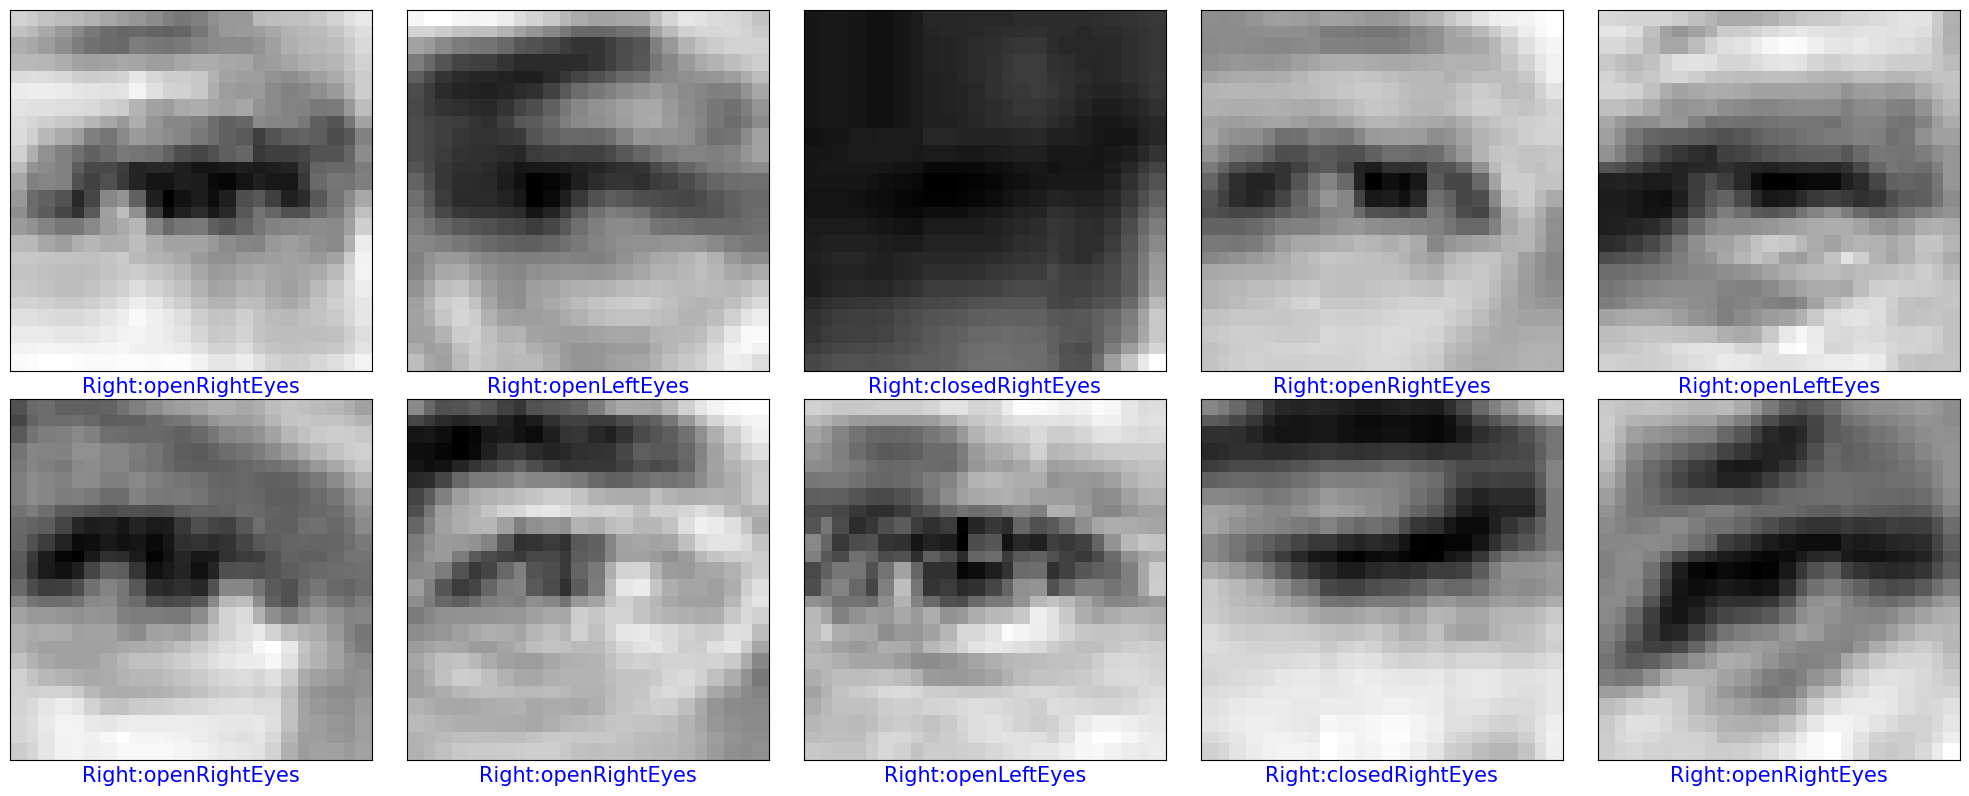

In [18]:
fig, axes = plt.subplots(2,5,figsize = (20,8))

for idx in range(10):
    ax = axes[idx//5,idx % 5]
    id = np.random.randint(0,len(y_test_label))
    ax.set(xticks=[], yticks=[])
    ax.imshow(x_test[id], cmap='gray')
    if y_test_label[id] != y_prob[id]:
        color = 'red'
    else:
        color = 'blue'
    title = f'True:{labels[y_test_label[id]]} \n + Pred:{labels[y_prob[id]]}' if y_test_label[id] != y_prob[id] else f'Right:{labels[y_test_label[id]]}'

    ax.set_xlabel(title, color = color, fontsize = 15)

plt.tight_layout()
plt.show()


In [19]:
count_left_right = 0
count_closed_open = 0
for i in range(len(y_prob)):
    if(y_prob[i] !=  y_test_label[i]):
        if(labels[y_prob[i]][0] != labels[y_test_label[i]][0]):
            count_closed_open += 1
        if(labels[y_prob[i]][6] != labels[y_test_label[i]][6]):
            count_left_right += 1

print("left_right: ", count_left_right)
print("closed_open: ", count_closed_open)
print(f"Percent_left_right: {(count_left_right/(count_closed_open + count_left_right)) : .2f}")
print(f"Percent_closed_open: {(count_closed_open/(count_closed_open + count_left_right)) : .2f}")

left_right:  130
closed_open:  56
Percent_left_right:  0.70
Percent_closed_open:  0.30


In [20]:
def bounding_box_left(landmarks):
    left_eye_region = np.array([(landmarks.part(36).x, landmarks.part(36).y),
                        (landmarks.part(39).x, landmarks.part(39).y),
                        (landmarks.part(37).x, landmarks.part(37).y),
                        (landmarks.part(38).x, landmarks.part(38).y),
                        (landmarks.part(41).x, landmarks.part(41).y),
                        (landmarks.part(40).x, landmarks.part(40).y)], np.int32)

    min_x = np.min(left_eye_region[:, 0])
    max_x = np.max(left_eye_region[:, 0])
    min_y = np.min(left_eye_region[:, 1])
    max_y = np.max(left_eye_region[:, 1])

    return min_x, max_x, min_y, max_y

In [21]:
def bounding_box_right(landmarks):
    left_eye_region = np.array([(landmarks.part(42).x, landmarks.part(42).y),
                        (landmarks.part(43).x, landmarks.part(43).y),
                        (landmarks.part(44).x, landmarks.part(44).y),
                        (landmarks.part(45).x, landmarks.part(45).y),
                        (landmarks.part(46).x, landmarks.part(46).y),
                        (landmarks.part(47).x, landmarks.part(47).y)], np.int32)

    min_x = np.min(left_eye_region[:, 0])
    max_x = np.max(left_eye_region[:, 0])
    min_y = np.min(left_eye_region[:, 1])
    max_y = np.max(left_eye_region[:, 1])

    return min_x, max_x, min_y, max_y

In [ ]:
cap = cv2.VideoCapture(0)
detector = dlib.get_frontal_face_detector() 
predictor = dlib.shape_predictor(r'C:\Users\ADMIN\OneDrive\Desktop\CV_Eye\shape_predictor_68_face_landmarks.dat')

while True:
    ret, frame = cap.read()
    if not ret:
        break

  #  frame = cv2.flip(frame, 1)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)


    for face in faces:

        landmarks = predictor(gray, face)

        x_left_min, x_left_max, y_left_min, y_left_max  = bounding_box_left(landmarks)
        x_right_min, x_right_max, y_right_min, y_right_max = bounding_box_right(landmarks)

        #if x_left < 0 or y_left < 0 or x_right < 0 or y_right < 0:
         #   continue

        eye_left = frame[y_left_min - 10 : y_left_max + 10, x_left_min - 10 :x_left_max + 15]
        eye_right = frame[y_right_min - 10 : y_right_max + 10, x_right_min - 10 : x_right_max + 15]

        gray_left = cv2.cvtColor(eye_left, cv2.COLOR_BGR2GRAY)
        gray_right = cv2.cvtColor(eye_right, cv2.COLOR_BGR2GRAY)

        gray_left = gray_left / 255.0
        gray_right = gray_right / 255.0

        gray_left = cv2.resize(gray_left,(64,64))
        gray_right = cv2.resize(gray_right,(64,64))


        img_left = gray_left.reshape(1,64,64,1)
        img_right = gray_right.reshape(1,64,64,1)
        
        pre_left = cnn.predict(img_left)
        pre_right = cnn.predict(img_right)

        label_ind_left = np.argmax(pre_left, axis= 1)[0]
        label_ind_right = np.argmax(pre_right, axis= 1)[0]

        if 'closed' in labels[label_ind_left]:
            label_left = 'closed'
        else:
            label_left = 'open'
        if 'closed' in labels[label_ind_right]:
            label_right = 'closed'
        else:
            label_right = 'open'
        
        color_left = (0, 255, 0) if label_left == 'open' else (255, 0, 0)
        color_right = (0, 255, 0) if label_right == 'open' else (255, 0, 0)
        cv2.rectangle(frame, (x_left_min - 10, y_left_min - 10),(x_left_max + 15, y_left_max + 10 ), color_left, 2)
        cv2.rectangle(frame, (x_right_min - 10, y_right_min - 10 ),(x_right_max + 15, y_right_max + 10), color_right, 2)

        cv2.putText(frame, labels[label_ind_left], (x_left_min - 125 , y_left_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_left, 2)
        cv2.putText(frame, labels[label_ind_right], (x_right_min + 50, y_right_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_right, 2)
        cv2.imshow('img_left', img_left[0,:,:,0])
        cv2.imshow('img_right', img_right[0,:,:,0])

    cv2.imshow('',frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()






1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
openLeftEyes


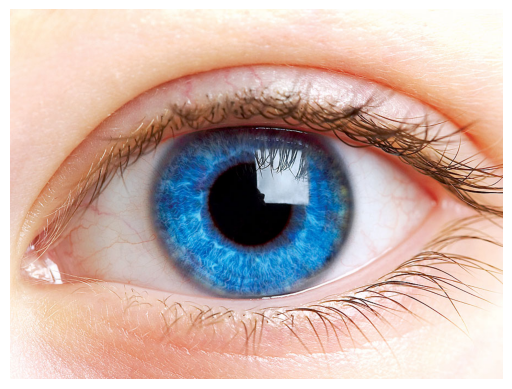

In [27]:
from tensorflow.keras.preprocessing import image

img = image.load_img(r'C:\Users\ADMIN\OneDrive\Desktop\CV_Eye\mat1_QASR.jpg', target_size = (64,64))
img_array = image.img_to_array(img)

img_gray = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_RGB2GRAY)

img_gray = img_gray.reshape(1, 64, 64, 1)

pre = model.predict(img_gray)
ind = np.argmax(pre, axis=1)
print(labels[ind[0]])

image = cv2.imread(r'C:\Users\ADMIN\OneDrive\Desktop\CV_Eye\mat1_QASR.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
plt.axis('off')
plt.imshow(image)